# Evaluate MedDRA Coding similarity to verbatim using Universal Sentence Encoder with Transformer

The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

In this notebook, I will use the model which is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. The universal-sentence-encoder-large model is trained with a Transformer encoder.

The size of the model is about 800MB.

This notebook ran on Sagemaker.

# Getting Started

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import keras.layers as layers
from keras.models import Model
from keras import backend as K
np.random.seed(10)

Using TensorFlow backend.


In [2]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [3]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/3'.
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 180.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 380.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 580.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 780.00MB
INFO:tensorflow:Downloaded https://tfhub.dev/google/universal-sentence-encoder-large/3, Total size: 810.60MB
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/3'.
Message: Elephant
Embedding size: 512
Embedding: [0.04498473182320595, -0.057433925569057465, 0.0022114794701337814, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.0556

In [4]:
# Compute a representation for each message, showing various lengths supported.
messages = ["That band rocks!", "That song is really cool."]

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))
message_embeddings

array([[ 0.00341095, -0.0381117 , -0.01249462, ..., -0.03188571,
         0.03693527, -0.04350929],
       [ 0.00599075, -0.03070364,  0.02946818, ..., -0.01874219,
         0.05244366,  0.01933832]], dtype=float32)

In [5]:
embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value
embed_size

512

In [6]:
!wget https://raw.githubusercontent.com/Tony607/Keras-Text-Transfer-Learning/master/train_5500.txt
!wget https://raw.githubusercontent.com/Tony607/Keras-Text-Transfer-Learning/master/test_data.txt

--2019-02-10 02:13:44--  https://raw.githubusercontent.com/Tony607/Keras-Text-Transfer-Learning/master/train_5500.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335860 (328K) [text/plain]
Saving to: ‘train_5500.txt’

train_5500.txt      100%[===================>] 327.99K  --.-KB/s    in 0.01s   

2019-02-10 02:13:45 (26.2 MB/s) - ‘train_5500.txt’ saved [335860/335860]

--2019-02-10 02:13:45--  https://raw.githubusercontent.com/Tony607/Keras-Text-Transfer-Learning/master/test_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23354 (23K) [text/plain]
Saving to: ‘test_data.txt’

test_data.txt      

In [7]:
def get_dataframe(filename):
    lines = open(filename, 'r').read().splitlines()
    data = []
    for i in range(0, len(lines)):
        label = lines[i].split(' ')[0]
        label = label.split(":")[0]
        text = ' '.join(lines[i].split(' ')[1:])
        text = re.sub('[^A-Za-z0-9 ,\?\'\"-._\+\!/\`@=;:]+', '', text)
        data.append([label, text])

    df = pd.DataFrame(data, columns=['label', 'text'])
    df.label = df.label.astype('category')
    return df

df_train = get_dataframe('train_5500.txt')
df_train.head()

,label,text
0,DESC,How did serfdom develop in and then leave Russ...
1,ENTY,What films featured the character Popeye Doyle ?
2,DESC,How can I find a list of celebrities ' real na...
3,ENTY,What fowl grabs the spotlight after the Chines...
4,ABBR,What is the full form of .com ?


In [8]:
df_train = get_dataframe('test_data.txt')

In [9]:
category_counts = len(df_train.label.cat.categories)
category_counts

6

## Wrap embed module in a Lambda layer
Explicitly cast the input as a string

In [10]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [11]:
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text)
dense = layers.Dense(256, activation='relu')(embedding)
pred = layers.Dense(category_counts, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 132,870
Trainable params: 132,870
Non-trainable params: 0
_________________________________________________________________


In [12]:
train_text = df_train['text'].tolist()
train_text = np.array(train_text, dtype=object)[:, np.newaxis]

train_label = np.asarray(pd.get_dummies(df_train.label), dtype = np.int8)

In [13]:
train_text.shape

(500, 1)

In [14]:
train_label.shape

(500, 6)

In [15]:
train_label[:3]

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0]], dtype=int8)

In [16]:
df_test = get_dataframe('test_data.txt')

In [17]:
test_text = df_test['text'].tolist()
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = np.asarray(pd.get_dummies(df_test.label), dtype = np.int8)

## Train Keras model and save weights
This only train and save our Keras layers not the embed module' weights.

In [18]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  history = model.fit(train_text, 
            train_label,
            validation_data=(test_text, test_label),
            epochs=10,
            batch_size=32)
  model.save_weights('./model.h5')

Train on 500 samples, validate on 500 samples
Epoch 1/10
500/500 [==============================] - 10s 19ms/step - loss: 1.5725 - acc: 0.5820 - val_loss: 1.2812 - val_acc: 0.7820
Epoch 2/10
500/500 [==============================] - 4s 8ms/step - loss: 1.0754 - acc: 0.8140 - val_loss: 0.8339 - val_acc: 0.8600
Epoch 3/10
500/500 [==============================] - 4s 8ms/step - loss: 0.7070 - acc: 0.8820 - val_loss: 0.5620 - val_acc: 0.9000
Epoch 4/10
500/500 [==============================] - 4s 8ms/step - loss: 0.4949 - acc: 0.8960 - val_loss: 0.4182 - val_acc: 0.9060
Epoch 5/10
500/500 [==============================] - 4s 8ms/step - loss: 0.3875 - acc: 0.9120 - val_loss: 0.3355 - val_acc: 0.9240
Epoch 6/10
500/500 [==============================] - 4s 8ms/step - loss: 0.3143 - acc: 0.9200 - val_loss: 0.2819 - val_acc: 0.9300
Epoch 7/10
500/500 [==============================] - 4s 8ms/step - loss: 0.2697 - acc: 0.9280 - val_loss: 0.2396 - val_acc: 0.9380
Epoch 8/10
500/500 [========

In [19]:
!ls -alh | grep model.h5

-rw-rw-r--  1 ec2-user ec2-user 534K Feb 10 02:14 model.h5


## Make predictions

In [20]:
new_text = ["In what year did the titanic sink ?", "What is the highest peak in California ?", "Who invented the light bulb ?"]
new_text = np.array(new_text, dtype=object)[:, np.newaxis]
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model.h5')  
  predicts = model.predict(new_text, batch_size=32)

In [21]:
predicts

array([[8.6309177e-05, 6.0993282e-04, 8.9653727e-04, 7.8736040e-05,
        4.1685201e-04, 9.9791163e-01],
       [1.6639127e-03, 2.2343441e-03, 2.3854697e-02, 2.3831504e-03,
        6.6457403e-01, 3.0528989e-01],
       [5.8392278e-04, 9.6685765e-04, 4.6175569e-02, 9.4956499e-01,
        2.1396172e-03, 5.6900643e-04]], dtype=float32)

In [22]:
categories = df_train.label.cat.categories.tolist()
predict_logits = predicts.argmax(axis=1)
predict_labels = [categories[logit] for logit in predict_logits]
predict_labels

['NUM', 'LOC', 'HUM']

# Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [23]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
  plot_similarity(messages_, message_embeddings_, 90)

## Similarity Visualized
Here we show the similarity in a heat map. The final graph is a 9x9 matrix where each entry `[i, j]` is colored based on the inner product of the encodings for sentence `i` and `j`.

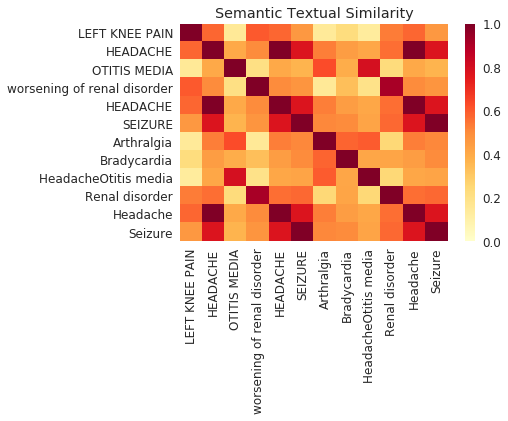

In [25]:
messages = [
    # AETERM
      'LEFT KNEE PAIN',
      'HEADACHE',
      'OTITIS MEDIA',
      'worsening of renal disorder',
      'HEADACHE',
      'SEIZURE',
 #AEDECOD
      'Arthralgia',
      'Bradycardia',
      'Headache'
      'Otitis media',
      'Renal disorder',
      'Headache',
      'Seizure',
]

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)